# Campaign optimization in the financial services industry

Your goal:

The bank wants to improve its revenues from direct marketing campaigns. It is your task to help them to achieve this goal in a data-driven way. Keep in mind following two limitations:

1. They can only contact 120 customers next campaign period.

2. Each customer can only be targeted once with one specific product offer

You can offer 1,2 or 3 products in a single product offer, but there are different costs associated with it:

* Offering one product: €2.00
* Offering two products: €5.00
* Offering three products: €10.00

## Initiation

In [252]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

import sys

from pandas               import DataFrame
from pandas               import Series
from pandas               import read_csv
from pandas               import get_dummies
from numpy                import array
from numpy                import random
from numpy                import where
from numpy                import nan
from scipy.stats.mstats   import winsorize
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from matplotlib           import pyplot

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from scipy.stats          import pearsonr

import seaborn as sns

Wall time: 996 µs


## 1. Manipulating Data

In [253]:
%%time
# Read train, test
# Description=pd.read_excel('./data/Case_data_cvt.xlsx',sheet_name='Description')
Soc_Dem=pd.read_excel('./data/Case_data_cvt.xlsx',sheet_name='Soc_Dem')
Actual_products=pd.read_excel('./data/Case_data_cvt.xlsx',sheet_name='Actual_products')
Transaction_flows=pd.read_excel('./data/Case_data_cvt.xlsx',sheet_name='Transaction_flows')
Product_sales=pd.read_excel('./data/Case_data_cvt.xlsx',sheet_name='Product_sales')

Wall time: 2.55 s


In [254]:
(1615-969)

646

In [255]:
(1615-969)/1615

0.4

In [256]:
Soc_Dem.info()
Soc_Dem.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Client  1615 non-null   int64 
 1   Gen     1612 non-null   object
 2   Age     1615 non-null   int64 
 3   LOR     1615 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 50.6+ KB


,Client,Gen,Age,LOR
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106


In [257]:
Actual_products.info()
Actual_products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      1615 non-null   int64  
 1   Count_CA    1615 non-null   int64  
 2   Count_SA    426 non-null    float64
 3   Count_MF    306 non-null    float64
 4   Count_OVD   419 non-null    float64
 5   Count_CC    170 non-null    float64
 6   Count_CL    135 non-null    float64
 7   ActBal_CA   1615 non-null   float64
 8   ActBal_SA   426 non-null    float64
 9   ActBal_MF   306 non-null    float64
 10  ActBal_OVD  419 non-null    float64
 11  ActBal_CC   170 non-null    float64
 12  ActBal_CL   135 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 164.1 KB


,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [258]:
Transaction_flows.info()
Transaction_flows.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1587 non-null   int64  
 1   VolumeCred                    1587 non-null   float64
 2   VolumeCred_CA                 1587 non-null   float64
 3   TransactionsCred              1587 non-null   int64  
 4   TransactionsCred_CA           1587 non-null   int64  
 5   VolumeDeb                     1587 non-null   float64
 6   VolumeDeb_CA                  1587 non-null   float64
 7   VolumeDebCash_Card            1587 non-null   float64
 8   VolumeDebCashless_Card        1587 non-null   float64
 9   VolumeDeb_PaymentOrder        1587 non-null   float64
 10  TransactionsDeb               1587 non-null   int64  
 11  TransactionsDeb_CA            1587 non-null   int64  
 12  TransactionsDebCash_Card      1587 non-null   int64  
 13  Tra

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0


In [259]:
Product_sales.info()
Product_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      969 non-null    int64  
 1   Sale_MF     969 non-null    int64  
 2   Sale_CC     969 non-null    int64  
 3   Sale_CL     969 non-null    int64  
 4   Revenue_MF  969 non-null    float64
 5   Revenue_CC  969 non-null    float64
 6   Revenue_CL  969 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 53.1 KB


,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


## 2. Processing data

### 2.1 Create a new column : 
######         profit  =  revenue  -  cost

In [260]:
# caculate the total cost of each client
Product_sales['total_n_procducts']=Product_sales.Sale_MF+Product_sales.Sale_CC+Product_sales.Sale_CL
Product_sales.loc[Product_sales['total_n_procducts'] == 0, 'cost'] = 0
Product_sales.loc[Product_sales['total_n_procducts'] == 1, 'cost'] = 2
Product_sales.loc[Product_sales['total_n_procducts'] == 2, 'cost'] = 5
Product_sales.loc[Product_sales['total_n_procducts'] == 3, 'cost'] =10
Product_sales.head(3)

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,total_n_procducts,cost
0,1094,0,1,0,0.000000,5.138571,0.0000,1,2.0
1,1484,1,0,1,25.609107,0.000000,8.7225,2,5.0
2,20,0,1,0,0.000000,3.822500,0.0000,1,2.0


In [261]:
# caculate the total revenue of each client
Product_sales['total_revenue']=Product_sales.Sale_MF*Product_sales.Revenue_MF+Product_sales.Sale_CC*Product_sales.Revenue_CC+Product_sales.Sale_CL*Product_sales.Revenue_CL

# caculate the total profit of each client
Product_sales['profit']=Product_sales.total_revenue - Product_sales.cost
Product_sales.sort_values(by=['profit'], ascending = False)
Product_sales

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,total_n_procducts,cost,total_revenue,profit
0,1094,0,1,0,0.000000,5.138571,0.000000,1,2.0,5.138571,3.138571
1,1484,1,0,1,25.609107,0.000000,8.722500,2,5.0,34.331607,29.331607
2,20,0,1,0,0.000000,3.822500,0.000000,1,2.0,3.822500,1.822500
3,1193,0,0,0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000
4,142,0,0,0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
964,1316,0,0,1,0.000000,0.000000,3.317500,1,2.0,3.317500,1.317500
965,905,1,1,1,1.761071,0.892857,13.166786,3,10.0,15.820714,5.820714
966,938,0,1,1,0.000000,4.928571,7.812143,2,5.0,12.740714,7.740714
967,434,0,0,0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000


Client               0.0
Sale_MF              0.0
Sale_CC              0.0
Sale_CL              0.0
Revenue_MF           0.0
Revenue_CC           0.0
Revenue_CL           0.0
total_n_procducts    0.0
cost                 0.0
total_revenue        0.0
profit               0.0
dtype: float64
Client               0
Sale_MF              0
Sale_CC              0
Sale_CL              0
Revenue_MF           0
Revenue_CC           0
Revenue_CL           0
total_n_procducts    0
cost                 0
total_revenue        0
profit               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Client             969 non-null    int64  
 1   Sale_MF            969 non-null    int64  
 2   Sale_CC            969 non-null    int64  
 3   Sale_CL            969 non-null    int64  
 4   Revenue_MF         969 non-null    float64
 5 

<AxesSubplot:>

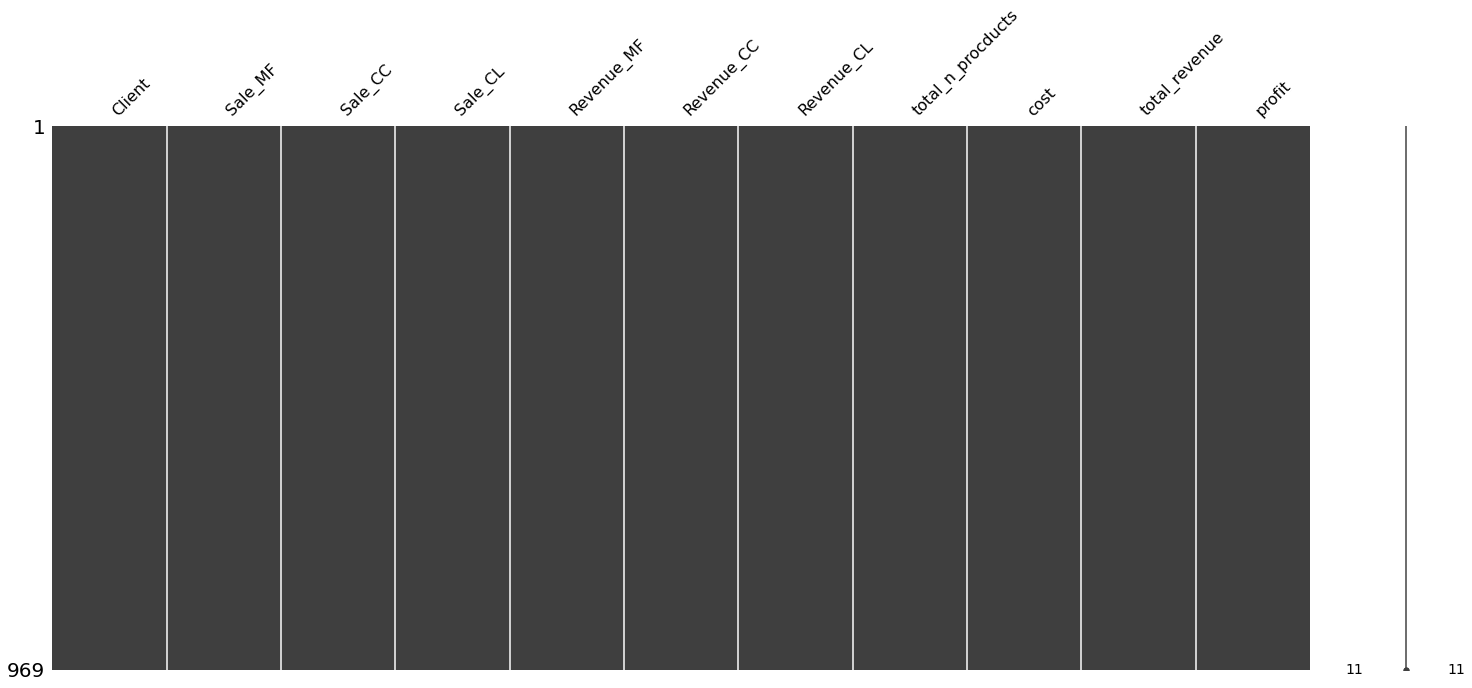

In [262]:
# check missing values
misingdata = Product_sales
print(misingdata.isna().sum()/misingdata.shape[0])
print(misingdata.isna().sum())
misingdata.info()
import missingno as msno # pip install missingno
%matplotlib inline
msno.matrix(misingdata)

### 2.2 Merge all the data

In [263]:
# merge all the data
SA= pd.merge(Soc_Dem, Actual_products, on='Client', how='left')
SAT= pd.merge(SA, Transaction_flows, on='Client', how='left')
# merge the Product_sales with only the profit, 
# due to the test set don't have the variables in the Product_sales
#he profit is the target will be predicted 
SATP= pd.merge(SAT, Product_sales[['Client','profit']], on='Client', how='left')

# SATP.head()

### 2.3 data visulization

C:\Users\MRZHE\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Gen', ylabel='count'>

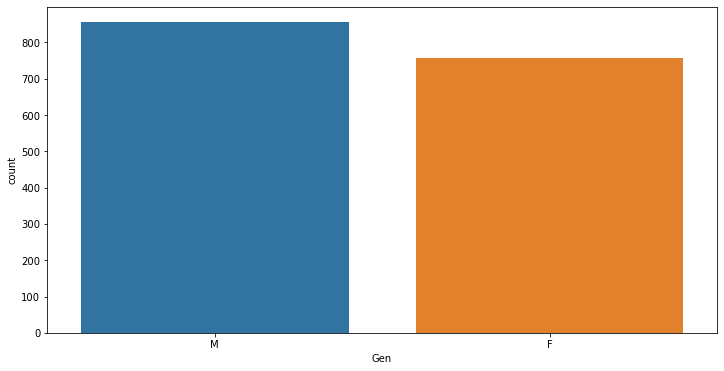

In [264]:
# the graph shows the male/female are almost balanced
plt.figure(figsize=(12,6))
plt.xticks(rotation=0)
sns.countplot(SATP['Gen'].dropna(axis=0))

(-0.5, 1.5, -10.0, 500.0)

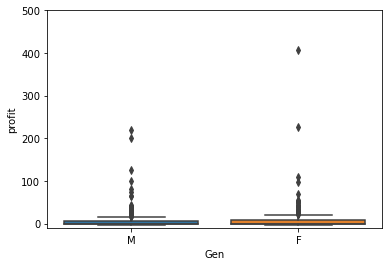

In [265]:
# Gender
# gender has little impact on profits, some of the female will contribute high profit
var='Gen'
data=pd.concat([SATP['profit'].dropna(axis=0),SATP[SATP['profit'].notna()][var]],axis=1)
fig=sns.boxplot(x=var,y='profit',data=data)
fig.axis(ymin=-10,ymax=500)

### 2.4  missing values

<AxesSubplot:>

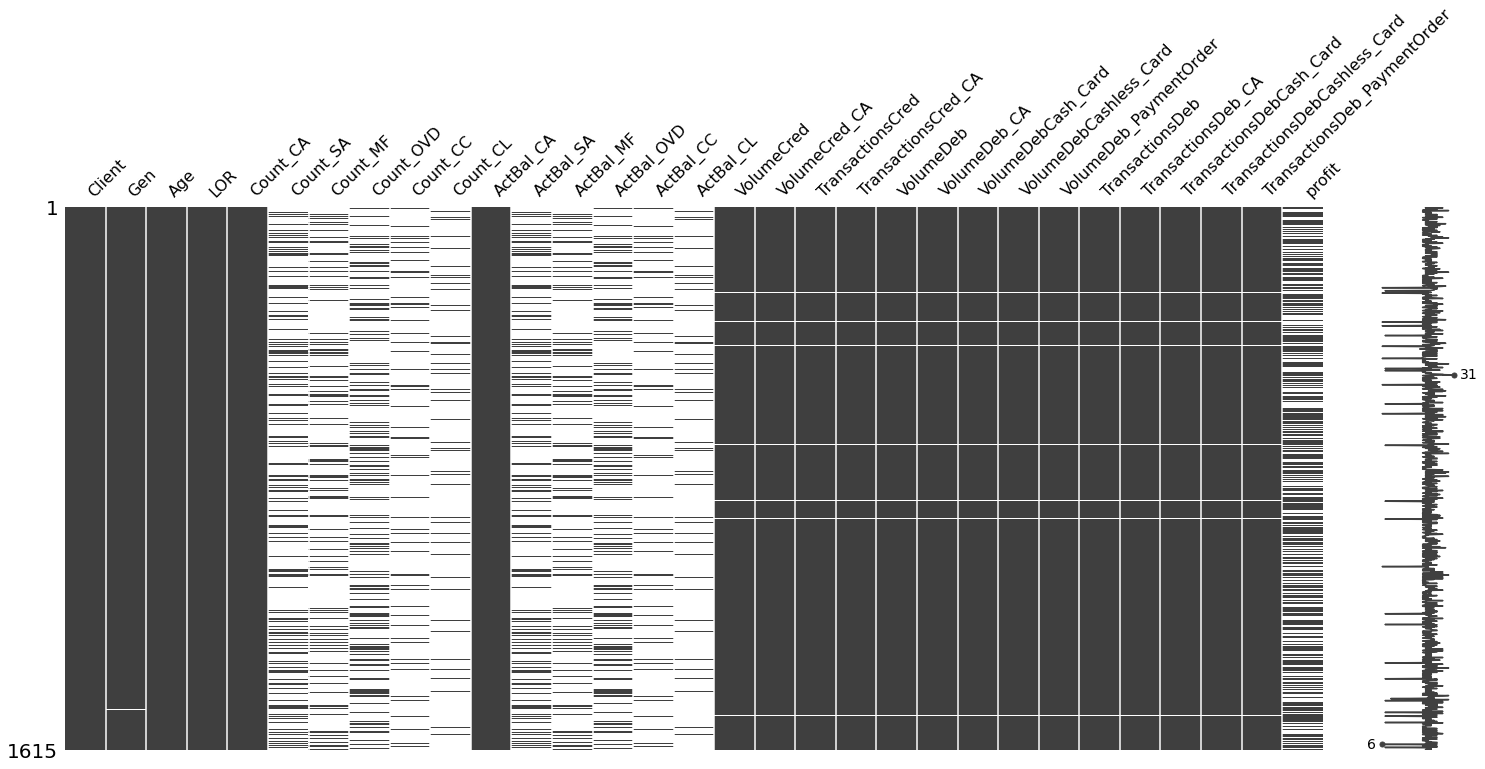

In [266]:
import missingno as msno # pip install missingno
%matplotlib inline
msno.matrix(SATP)

In [267]:
# List dummary variables to track missing values imputation
na_vars = []

# List dummary variables to track missing values imputation
num_vars = ['Count_SA', 'Count_MF','Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA',
            'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL','VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

# Numerical variables
# Build the missing value imputor using the constant
imp = SimpleImputer(missing_values=np.nan, strategy='constant', add_indicator=True)
imp.fit(SATP[num_vars])
# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars
# Apply on SATP
SATP[impute_vars] = pd.DataFrame(imp.transform(SATP[num_vars]), columns=impute_vars)

In [268]:
SATP.columns

Index(['Client', 'Gen', 'Age', 'LOR', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'profit', 'Count_SA_na', 'Count_MF_na',
       'Count_OVD_na', 'Count_CC_na', 'Count_CL_na', 'ActBal_SA_na',
       'ActBal_MF_na', 'ActBal_OVD_na', 'ActBal_CC_na', 'ActBal_CL_na',
       'VolumeCred_na', 'VolumeCred_CA_na', 'TransactionsCred_na',
       'TransactionsCred_CA_na', 'VolumeDeb_na', 'VolumeDeb_CA_na',
       'VolumeDebCash_Card_na', 'VolumeDebCashless_Card_na',
       'VolumeDeb_PaymentOrder_na', 'TransactionsDeb_na',
       'Transact

### 2.3.3 variable correlation

<AxesSubplot:>

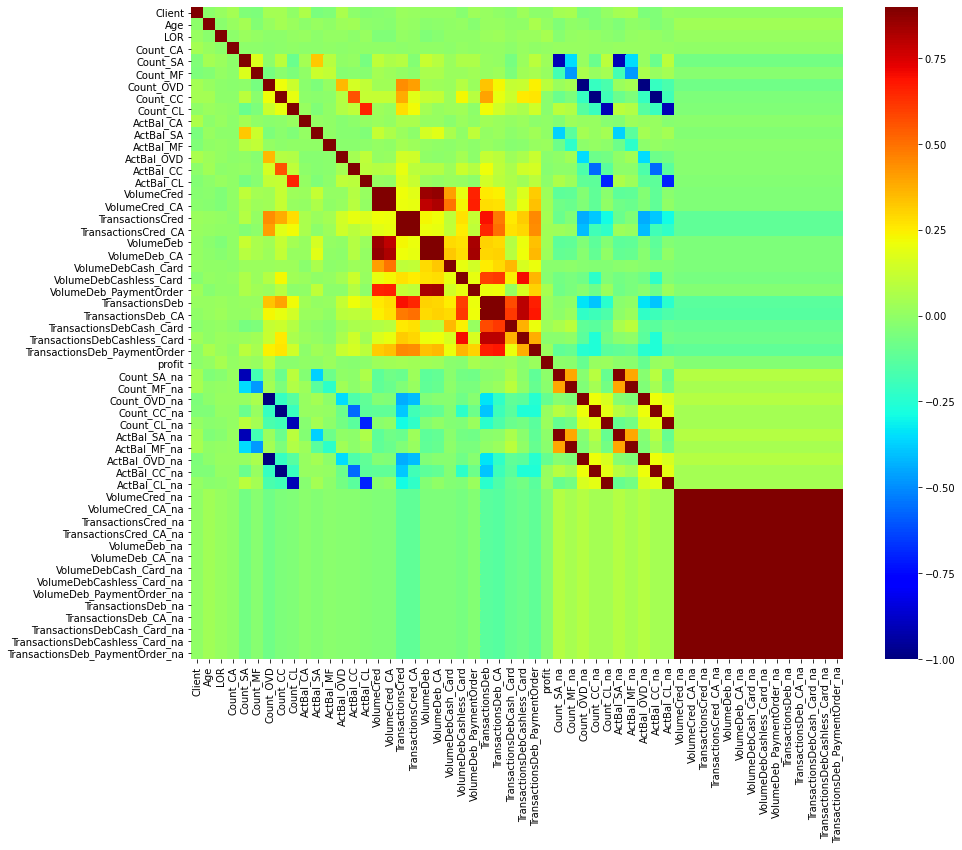

In [269]:
# all features correlatons
corrmat = SATP.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='jet')

<AxesSubplot:>

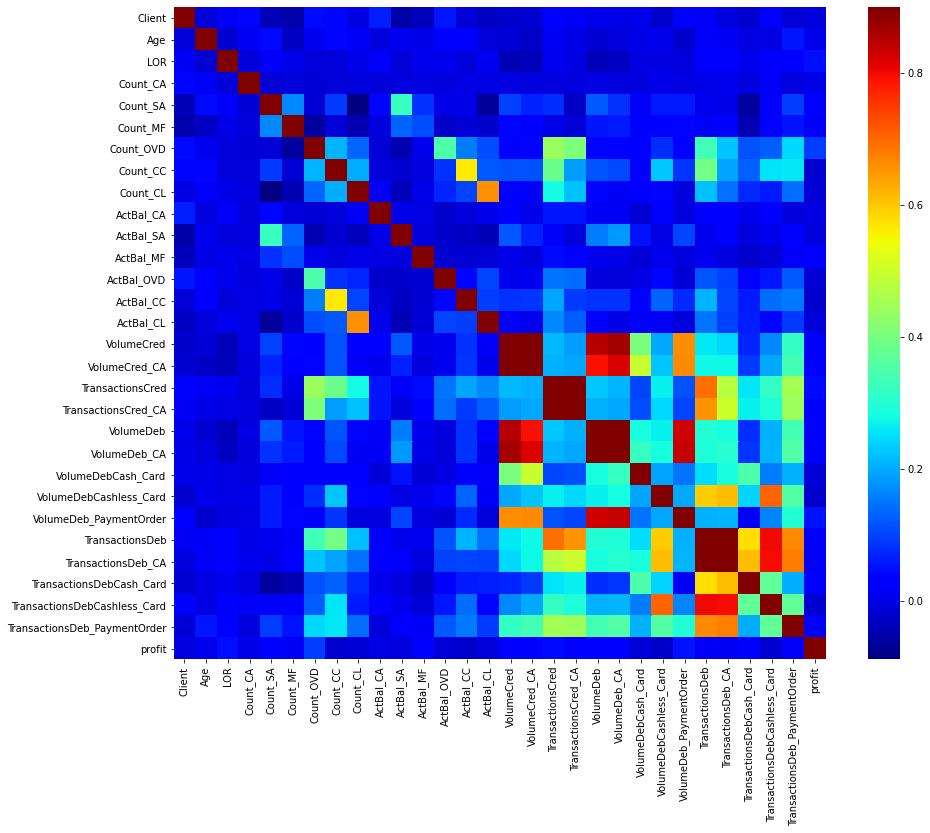

In [270]:
# only the non-track features
# it seems VolumeDebCash_Card have high correlation with the VolumeDeb, 
# due to the Overdrafts are often limited by credit limits
cor_vars=['Client', 'Gen', 'Age', 'LOR', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'profit']
corrmat = SATP[cor_vars].corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='jet')

### 2.3.4 Value representation (cat => num)

In [271]:
# fill the missing value in profit with 0, and set a track col for partition
SATP['profit_miss'] = where(SATP['profit'].isna(), 1, 0)
SATP['profit'].fillna(0,inplace=True)

In [272]:
SATP.dtypes

Client                               int64
Gen                                 object
Age                                  int64
LOR                                  int64
Count_CA                             int64
Count_SA                           float64
Count_MF                           float64
Count_OVD                          float64
Count_CC                           float64
Count_CL                           float64
ActBal_CA                          float64
ActBal_SA                          float64
ActBal_MF                          float64
ActBal_OVD                         float64
ActBal_CC                          float64
ActBal_CL                          float64
VolumeCred                         float64
VolumeCred_CA                      float64
TransactionsCred                   float64
TransactionsCred_CA                float64
VolumeDeb                          float64
VolumeDeb_CA                       float64
VolumeDebCash_Card                 float64
VolumeDebCa

In [273]:
# check the duplicated obs
dd=SATP
dd[dd.Client.duplicated()]

,Client,Gen,Age,LOR,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb_CA_na,VolumeDebCash_Card_na,VolumeDebCashless_Card_na,VolumeDeb_PaymentOrder_na,TransactionsDeb_na,TransactionsDeb_CA_na,TransactionsDebCash_Card_na,TransactionsDebCashless_Card_na,TransactionsDeb_PaymentOrder_na,profit_miss


In [274]:
# dummy for all categorial variables
trainingSet=SATP.copy()
types = trainingSet.dtypes.to_dict()
from pandas               import DataFrame
def treatCategorical (variable: str, inDataSet: DataFrame) -> DataFrame:
    inDataSet[variable] = inDataSet[variable].replace({nan: "missing"})
    inDataSet           = inDataSet.join(get_dummies(inDataSet[variable], prefix = f"fl_{variable}_is", drop_first = True))
    inDataSet           = inDataSet.drop(columns=[variable])
    return inDataSet

def treatContinuous (variable: str, inDataSet: DataFrame) -> DataFrame:
    #trainingSet[f"fl_{variable}_is_missing"] = where(trainingSet[variable].isnull(), 1, 0)
    trainingSet[variable] = trainingSet[variable].replace({nan: 0.0})
    trainingSet[variable] = winsorize(array(trainingSet[variable].astype(float)), limits = [0.00, 0.01])
    return inDataSet

for column in trainingSet.columns:
    columnType = types[column]
    print(f"{column} : {columnType}")
    if columnType not in ["int64","float64","int32"]:
        trainingSet = treatCategorical(variable = column, inDataSet = SATP)

Client : int64
Gen : object
Age : int64
LOR : int64
Count_CA : int64
Count_SA : float64
Count_MF : float64
Count_OVD : float64
Count_CC : float64
Count_CL : float64
ActBal_CA : float64
ActBal_SA : float64
ActBal_MF : float64
ActBal_OVD : float64
ActBal_CC : float64
ActBal_CL : float64
VolumeCred : float64
VolumeCred_CA : float64
TransactionsCred : float64
TransactionsCred_CA : float64
VolumeDeb : float64
VolumeDeb_CA : float64
VolumeDebCash_Card : float64
VolumeDebCashless_Card : float64
VolumeDeb_PaymentOrder : float64
TransactionsDeb : float64
TransactionsDeb_CA : float64
TransactionsDebCash_Card : float64
TransactionsDebCashless_Card : float64
TransactionsDeb_PaymentOrder : float64
profit : float64
Count_SA_na : float64
Count_MF_na : float64
Count_OVD_na : float64
Count_CC_na : float64
Count_CL_na : float64
ActBal_SA_na : float64
ActBal_MF_na : float64
ActBal_OVD_na : float64
ActBal_CC_na : float64
ActBal_CL_na : float64
VolumeCred_na : float64
VolumeCred_CA_na : float64
Transaction

In [275]:
dd=trainingSet
dd[dd.Client.duplicated()]

,Client,Age,LOR,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCashless_Card_na,VolumeDeb_PaymentOrder_na,TransactionsDeb_na,TransactionsDeb_CA_na,TransactionsDebCash_Card_na,TransactionsDebCashless_Card_na,TransactionsDeb_PaymentOrder_na,profit_miss,fl_Gen_is_M,fl_Gen_is_missing


In [276]:
trainingSet.columns

Index(['Client', 'Age', 'LOR', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'profit', 'Count_SA_na', 'Count_MF_na',
       'Count_OVD_na', 'Count_CC_na', 'Count_CL_na', 'ActBal_SA_na',
       'ActBal_MF_na', 'ActBal_OVD_na', 'ActBal_CC_na', 'ActBal_CL_na',
       'VolumeCred_na', 'VolumeCred_CA_na', 'TransactionsCred_na',
       'TransactionsCred_CA_na', 'VolumeDeb_na', 'VolumeDeb_CA_na',
       'VolumeDebCash_Card_na', 'VolumeDebCashless_Card_na',
       'VolumeDeb_PaymentOrder_na', 'TransactionsDeb_na',
       'TransactionsDeb

### 2.3.5 drop columns with high coorelation

In [277]:
# drop columns with high coorelation
trainingSet=trainingSet[['Client', 'Age', 'LOR', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder','profit_miss', 'fl_Gen_is_M','profit',]].drop(['VolumeCred','TransactionsCred','VolumeDeb','TransactionsDeb','VolumeCred' ,'VolumeCred_CA'],axis=1)
trainingSet.columns

Index(['Client', 'Age', 'LOR', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'TransactionsCred_CA',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'profit_miss', 'fl_Gen_is_M', 'profit'],
      dtype='object')

In [278]:
# print('The mean of Gen is {}'.format(np.mean(SATP[['Gen']].dropna(axis=0))))
# print('The median of Gen is {}'.format(np.median(SATP[['Gen']].dropna(axis=0))))
# value, count = np.unique(SATP[['Gen']], return_counts=True)
# print('The mode of Gen is {}'.format(value[np.argmax(count)]))
# print('The standard Gen of Var72 is {}'.format(np.std(SATP[['Gen']].dropna(axis=0))))

In [279]:
trainingSet

,Client,Age,LOR,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,profit_miss,fl_Gen_is_M,profit
0,909,21,27,1,0.0,0.0,1.0,0.0,1.0,4.710714,...,178.571429,0.000000,166.571429,7.0,1.0,0.0,4.0,1,1,0.000000
1,1217,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,...,0.000000,0.000000,714.285714,1.0,0.0,0.0,1.0,0,1,0.000000
2,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,...,0.000000,0.000000,121.928571,6.0,0.0,0.0,1.0,0,0,-1.106071
3,1473,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,...,357.142857,444.597500,2076.785714,38.0,1.0,26.0,11.0,0,1,2.929643
4,1038,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,409,31,91,1,0.0,0.0,1.0,0.0,0.0,348.402857,...,178.571429,11.414286,271.714286,12.0,1.0,1.0,9.0,1,1,0.000000
1611,384,23,160,1,0.0,0.0,0.0,0.0,0.0,2418.876786,...,50.000000,37.372500,1.071429,8.0,2.0,5.0,1.0,0,1,13.613214
1612,977,46,59,1,0.0,0.0,0.0,0.0,0.0,2639.308571,...,75.000000,1.067857,0.035714,4.0,2.0,1.0,1.0,0,1,-0.570357
1613,629,61,173,1,0.0,2.0,0.0,0.0,0.0,61.766786,...,660.714286,41.355000,115.178571,17.0,3.0,5.0,8.0,0,0,47.080714


# 3. Partition data

In [280]:
# building training set filter by 60% of the raw data in the Product_sales
train=trainingSet[trainingSet['profit_miss']==0].drop('profit_miss',axis=1)
test=trainingSet[trainingSet['profit_miss']==1].drop('profit_miss',axis=1)
print("proportion of test set:",test.shape[0]/trainingSet.shape[0])
print("proportion of trian set:",train.shape[0]/trainingSet.shape[0])

proportion of test set: 0.4
proportion of trian set: 0.6


In [281]:
from ieseg import partition
from ieseg import roc
partitions = partition(dataFrame = train, splitStrategy = [0.7,0.3])
training_Set = partitions[0]
test_Set     = partitions[1]
y_train = training_Set.profit.values
y_train = train.profit.values

## 3.1 Feature importance detection

In [282]:
selectedFeatures = []
target = 'profit'

for column in train.columns:
    if column not in ("Client","profit"):
        (pearson,pvalue) = pearsonr(train[column],train[target])
        print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.05 else 0}")
        if pvalue < 0.05:
            selectedFeatures.append(column)

Age - p-vlue = 0.8673703528446169 - selected : 0
LOR - p-vlue = 0.13772484050847114 - selected : 0
Count_CA - p-vlue = 0.9456933115513029 - selected : 0
Count_SA - p-vlue = 0.4397549279017301 - selected : 0
Count_MF - p-vlue = 0.6898220998162231 - selected : 0
Count_OVD - p-vlue = 0.002567231599432423 - selected : 1
Count_CC - p-vlue = 0.6341180537896379 - selected : 0
Count_CL - p-vlue = 0.687268436573002 - selected : 0
ActBal_CA - p-vlue = 0.9302633854077986 - selected : 0
ActBal_SA - p-vlue = 0.9070484193829436 - selected : 0
ActBal_MF - p-vlue = 0.5291982909866962 - selected : 0
ActBal_OVD - p-vlue = 0.6598390549651522 - selected : 0
ActBal_CC - p-vlue = 0.5099027155099473 - selected : 0
ActBal_CL - p-vlue = 0.7810416934329493 - selected : 0
TransactionsCred_CA - p-vlue = 0.3107894809903242 - selected : 0
VolumeDeb_CA - p-vlue = 0.3688540820232805 - selected : 0
VolumeDebCash_Card - p-vlue = 0.6813776151657248 - selected : 0
VolumeDebCashless_Card - p-vlue = 0.5136768248673229 - se

In [283]:
selectedFeatures

['Count_OVD']

In [284]:
lasso=Lasso(alpha=0.001)
lasso.fit(train.drop(['Client','profit'],axis=1),y_train)

Lasso(alpha=0.001)

In [285]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=train.drop(['Client','profit'],axis=1).columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
Count_OVD,6.149405
Count_SA,1.111559
TransactionsDebCash_Card,0.245843
Count_CA,0.090211
TransactionsDeb_CA,0.080622
Count_MF,0.079061
LOR,0.015122
Age,0.010770
VolumeDeb_PaymentOrder,0.000608
ActBal_CL,0.000029


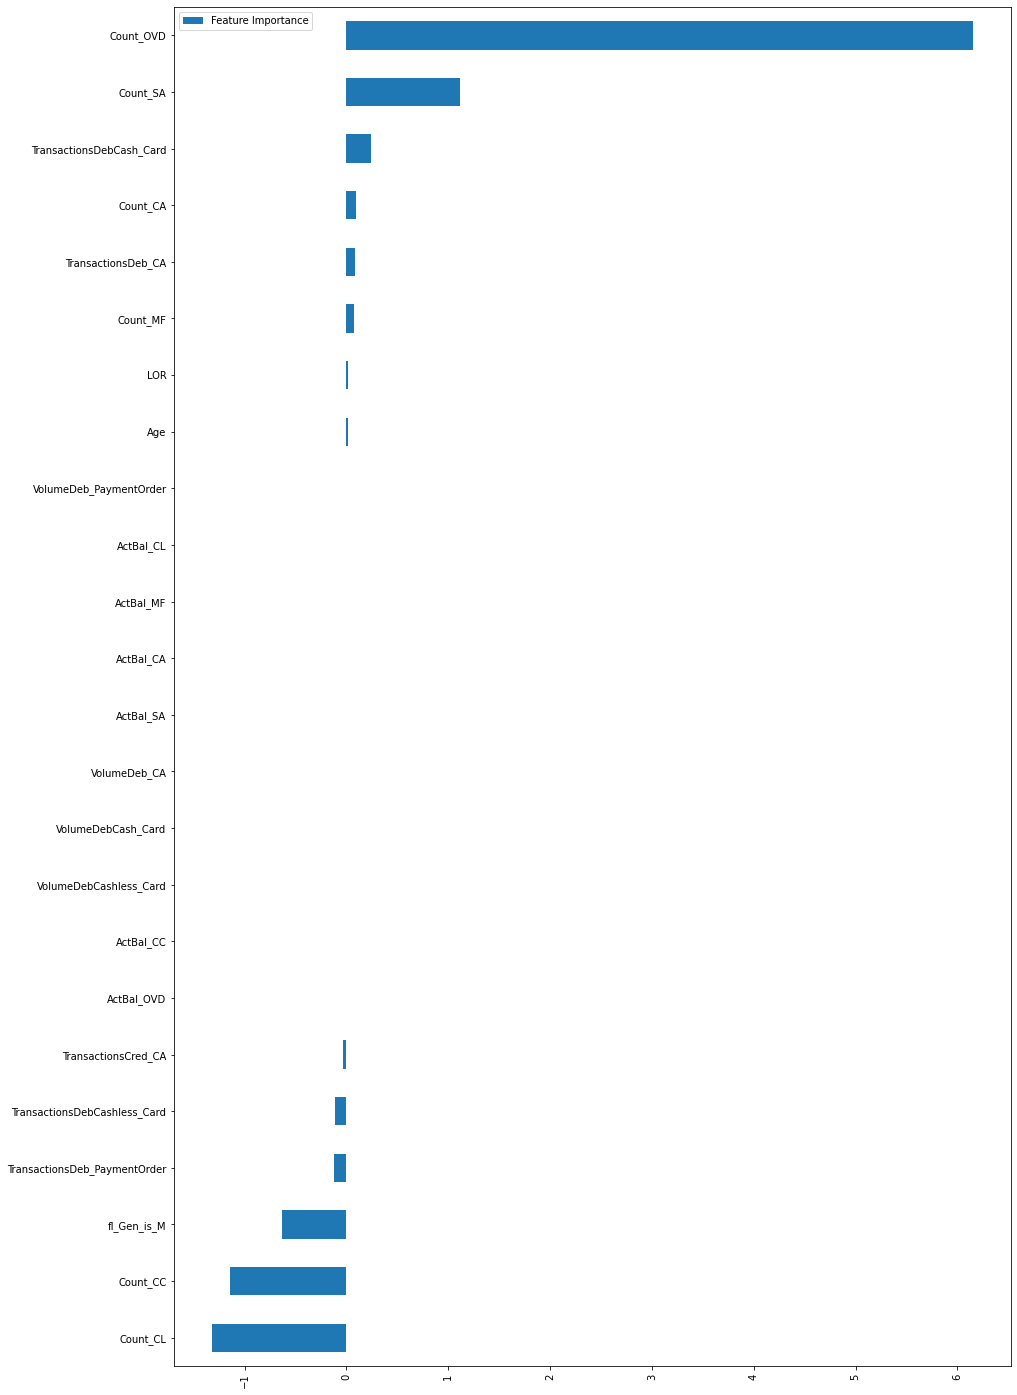

In [286]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [287]:
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

In [288]:
# Create several lists to handle variables
id_var = ['Client']
target_var = ["profit"]
predictors = [v for v in train.columns if v not in  id_var + target_var]
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

,predictor,fisherscore
9,ActBal_SA,0.511052
21,TransactionsDebCashless_Card,0.390096
6,Count_CC,0.369274
17,VolumeDebCashless_Card,0.354738
8,ActBal_CA,0.309008


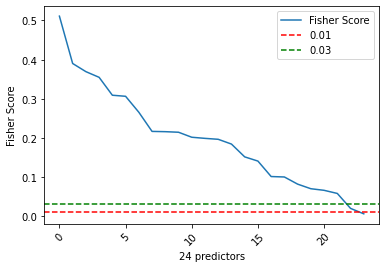

In [289]:
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axhline(y=0.01, linestyle='dashed', color='red')
plt.axhline(y=0.03, linestyle='dashed', color='green')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', '0.01', '0.03'])
plt.show()

In [290]:
# Select the top variables based on Fisher Score
#top_fs_vars = fs_df[fs_df['fisherscore'] >= 0.03]['predictor'].values
top_fs_vars = fs_df['predictor'].values[:15]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 15


array(['ActBal_SA', 'TransactionsDebCashless_Card', 'Count_CC',
       'VolumeDebCashless_Card', 'ActBal_CA', 'Count_CL',
       'TransactionsCred_CA', 'ActBal_CC', 'ActBal_CL', 'ActBal_MF',
       'ActBal_OVD', 'Count_CA', 'LOR', 'Count_SA',
       'TransactionsDebCash_Card'], dtype=object)

In [291]:
 len(['ActBal_SA', 'TransactionsDebCashless_Card',
       'VolumeDebCashless_Card', 'ActBal_CA', 'TransactionsCred_CA',
       'TransactionsCred', 'ActBal_CC', 'ActBal_CL', 'ActBal_MF',
       'ActBal_OVD', 'Count_CA', 'LOR', 'Count_SA',
       'TransactionsDebCash_Card', 'fl_Gen_is_M', 'profit', 'Client'])

17

In [292]:
top_fs_vars1=np.append(top_fs_vars,['profit','Client'])

In [293]:
train=train[top_fs_vars1]
test=test[top_fs_vars1]

# 4. basic model
_quantitative response as regression problems

## 4.1 Cross validatiion method

In [294]:
# cross_val_score默认使用K折交叉验证策略。此处先使用KFold的shuffle参数混洗数据
# neg_mean_squared_error：负均方误差，是损失函数，优化目标是使其最小化
# cross_val_score uses K-fold cross-validation strategy by default. Here first use KFold's shuffle parameter to shuffle the data
# neg_mean_squared_error: Negative mean squared error, is the loss function, the optimization goal is to minimize it

n_splits = 5
def nmse_cv(model):
    kf = KFold(n_splits, shuffle=True, random_state=42).get_n_splits(train.drop(['Client','profit'],axis=1).values)
    nmse = np.sqrt(-cross_val_score(model, train.drop(['Client','profit'],axis=1).values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return(nmse)

## 4.3  build models

In [295]:
# lasso/ElasticNet模型对异常值敏感，使用RobustScaler缩放有离群值的数据
# lasso/ElasticNet model is sensitive to outliers, use RobustScaler to scale data with outliers

lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# lasso = make_pipeline( Lasso(alpha=0.0005, random_state=1))
# ENet = make_pipeline( ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=0.25)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### 4.4  models performance

In [296]:
models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
names = ['Lasso', 'ELasticNet', 'KernelRidge', 'GradientBoosting', 'Xgboost', 'LGBM']
for model, name in zip(models, names):
    score = nmse_cv(model)
    # 验证结果返回5个分数，求均值和标准差
    # The verification result returns 5 scores, find the mean and standard deviation
    print('{} score:{:.4f} ({:.4f}) \n'.format(name, score.mean(), score.std()))

Lasso score:18.8630 (9.4652) 

ELasticNet score:18.8630 (9.4652) 



C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\l

KernelRidge score:35.7097 (23.0853) 

GradientBoosting score:19.2038 (9.4060) 

[05:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This 

## 4.5 Model training, prediction, evaluation

### 4.5.1 Define evaluation function

In [297]:
# Mean square error: The smaller the value of MSE, the better the accuracy of the prediction model
# 均方差：MSE的值越小，预测模型具有更好的精确度
def mse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [298]:
lasso.fit(train.drop(['Client','profit'],axis=1).values, y_train)
lasso_train_pred = lasso.predict(train.drop(['Client','profit'],axis=1).values)
lasso_pred = lasso.predict(test.drop(['Client','profit'],axis=1).values)
lasso_mse_train=(mse(y_train, lasso_train_pred))
print(mse(y_train, lasso_train_pred))

20.842984076730847


In [299]:
ENet.fit(train.drop(['Client','profit'],axis=1).values, y_train)
ENet_train_pred = ENet.predict(train.drop(['Client','profit'],axis=1).values)
ENet_pred = ENet.predict(test.drop(['Client','profit'],axis=1).values)
ENet_mse_train=mse(y_train, ENet_train_pred)
print(mse(y_train, ENet_train_pred))

20.84298407342539


In [300]:
# compare the training MSE between lasso and ENet
lasso_mse_train>ENet_mse_train

True

### 4.5.2 prediction

In [301]:
prediction = pd.DataFrame()
prediction['Id'] = test['Client'].values
prediction['profit'] = ENet_pred
prediction.to_csv('prediction.csv', index=False)

In [302]:
# check the number of profotable custmer
sum(prediction['profit']>0)

643

In [303]:
prediction.sort_values(by=['profit'], ascending = False)

,Id,profit
343,153,16.350180
620,314,14.889609
253,1365,14.424707
462,583,13.439076
404,350,13.306584
...,...,...
622,1604,0.857039
149,200,0.284185
288,829,-0.282104
341,214,-2.137089


In [304]:
# Select the top 120 customers with the highest profit
prediction.sort_values(by=['profit'], ascending = False)[:120]

,Id,profit
343,153,16.350180
620,314,14.889609
253,1365,14.424707
462,583,13.439076
404,350,13.306584
...,...,...
342,592,8.118737
332,379,8.110111
83,852,8.099327
64,9,8.094571


In [305]:
all_profit=prediction.sort_values(by=['profit'], ascending = False)
max_profit=prediction.sort_values(by=['profit'], ascending = False)[:120]

In [306]:
# Calculate the total profit for the first 120 customers
prediction.sort_values(by=['profit'], ascending = False)[:120]['profit'].sum()

1135.9603018284984

## 5 Predict which products each customer will buy
3 method of multi-label classification problem:
* Problem Transformation
    * Binary Relevance
    * Classifier Chains
    * Label Powerset
* Adapted Algorithm
* Ensemble approaches (not applied here)

Sci-kit learn provides inbuilt support of multi-label classification in some of the algorithm like Random Forest and Ridge regression. So, we can directly call them and predict the output.

### 5.1 dada preprocessing

In [307]:
trainingSet1=trainingSet.merge(Product_sales[['Client','Sale_MF','Sale_CC','Sale_CL']],\
                               on='Client',how='left').drop('profit',axis=1).fillna(0)
# building training set filter by 60% of the raw data in the Product_sales
train=trainingSet1[trainingSet1['profit_miss']==0].drop('profit_miss',axis=1)
test=trainingSet1[trainingSet1['profit_miss']==1].drop('profit_miss',axis=1)
print("proportion of test set:",test.shape[0]/trainingSet.shape[0])
print("proportion of trian set:",train.shape[0]/trainingSet.shape[0])

partitions = partition(dataFrame = train, splitStrategy = [0.7,0.3])
training_Set = partitions[0]
test_Set     = partitions[1]

X_train=training_Set.drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1)
y_train=training_Set[['Sale_MF', 'Sale_CC','Sale_CL']]
X_test =test_Set.drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1)
y_test=test_Set[['Sale_MF', 'Sale_CC','Sale_CL']]

proportion of test set: 0.4
proportion of trian set: 0.6


In [308]:
trainingSet1

,Client,Age,LOR,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,profit_miss,fl_Gen_is_M,Sale_MF,Sale_CC,Sale_CL
0,909,21,27,1,0.0,0.0,1.0,0.0,1.0,4.710714,...,166.571429,7.0,1.0,0.0,4.0,1,1,0.0,0.0,0.0
1,1217,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,...,714.285714,1.0,0.0,0.0,1.0,0,1,0.0,0.0,0.0
2,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,...,121.928571,6.0,0.0,0.0,1.0,0,0,0.0,1.0,0.0
3,1473,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,...,2076.785714,38.0,1.0,26.0,11.0,0,1,1.0,0.0,0.0
4,1038,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,...,0.000000,0.0,0.0,0.0,0.0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,409,31,91,1,0.0,0.0,1.0,0.0,0.0,348.402857,...,271.714286,12.0,1.0,1.0,9.0,1,1,0.0,0.0,0.0
1611,384,23,160,1,0.0,0.0,0.0,0.0,0.0,2418.876786,...,1.071429,8.0,2.0,5.0,1.0,0,1,0.0,1.0,1.0
1612,977,46,59,1,0.0,0.0,0.0,0.0,0.0,2639.308571,...,0.035714,4.0,2.0,1.0,1.0,0,1,1.0,0.0,0.0
1613,629,61,173,1,0.0,2.0,0.0,0.0,0.0,61.766786,...,115.178571,17.0,3.0,5.0,8.0,0,0,0.0,1.0,0.0


In [309]:
training_Set.columns

Index(['Client', 'Age', 'LOR', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'TransactionsCred_CA',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'fl_Gen_is_M', 'Sale_MF', 'Sale_CC',
       'Sale_CL'],
      dtype='object')

In [310]:
selected_var=['Client','ActBal_SA', 'TransactionsDebCashless_Card', 'Count_CC',
       'VolumeDebCashless_Card', 'ActBal_CA', 'Count_CL',
       'TransactionsCred_CA', 'ActBal_CC', 'ActBal_CL', 'ActBal_MF',
       'ActBal_OVD', 'Count_CA', 'LOR', 'Count_SA',
       'TransactionsDebCash_Card','Sale_MF', 'Sale_CC',
       'Sale_CL']

In [311]:
X_train=training_Set[selected_var].drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1)
y_train=training_Set[['Sale_MF', 'Sale_CC','Sale_CL']]
X_test =test_Set[selected_var].drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1)
y_test=test_Set[['Sale_MF', 'Sale_CC','Sale_CL']]

### 5.2  Binary Relevance

This is the simplest technique, which basically treats each label as a separate single class classification problem.

In [312]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [313]:
top_fs_vars

array(['ActBal_SA', 'TransactionsDebCashless_Card', 'Count_CC',
       'VolumeDebCashless_Card', 'ActBal_CA', 'Count_CL',
       'TransactionsCred_CA', 'ActBal_CC', 'ActBal_CL', 'ActBal_MF',
       'ActBal_OVD', 'Count_CA', 'LOR', 'Count_SA',
       'TransactionsDebCash_Card'], dtype=object)

##### 5.2.1  calculate the accuracy of our predictions

In [314]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.15517241379310345

It is most simple and efficient method but the only drawback of this method is that it doesn’t consider labels correlation because it treats every target variable independently.

### 5.3 Classifier Chains

In this, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.  

In [315]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.15517241379310345

The lower accuracy is maybe due to the absence of label correlation 

### 5.4 Label Powerset

It transform the problem into a multi-class problem with one multi-class classifier is trained on all unique label combinations found in the training data.

In [316]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.06896551724137931

In [317]:
classifier.fit(train.drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1),\
               train[['Sale_MF', 'Sale_CC','Sale_CL']])
# predict
product_pred = classifier.predict(test.drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1))

In [318]:
prediction_product = pd.DataFrame()
prediction_product['Id'] = test['Client']
prediction_product[['Sale_MF', 'Sale_CC','Sale_CL'] ]= product_pred.toarray()
max_profit.merge(prediction_product,on='Id',how='left')

,Id,profit,Sale_MF,Sale_CC,Sale_CL
0,153,16.350180,1,0,1
1,314,14.889609,1,0,1
2,1365,14.424707,1,1,0
3,583,13.439076,1,0,1
4,350,13.306584,1,1,0
...,...,...,...,...,...
115,592,8.118737,1,1,0
116,379,8.110111,0,0,0
117,852,8.099327,1,1,0
118,9,8.094571,1,1,0


The only disadvantage of this is that as the training data increases, number of classes become more. Thus, increasing the model complexity, and would result in a lower accuracy.

### 5.4 Adapted Algorithm

Adapted algorithm, as the name suggests, adapting the algorithm to directly perform multi-label classification, rather than transforming the problem into different subsets of problems.

In [319]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=20)

# train
classifier.fit(X_train, y_train.values)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test.values,predictions)


C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.42758620689655175

In [320]:
classifier.fit(train.drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1),\
               train[['Sale_MF', 'Sale_CC','Sale_CL']].values)
# predict
product_pred = classifier.predict(test.drop(['Sale_MF', 'Sale_CC','Sale_CL'],axis=1))
prediction_product = pd.DataFrame()
prediction_product['Id'] = test['Client']
prediction_product[['Sale_MF', 'Sale_CC','Sale_CL'] ]= product_pred.toarray()

C:\Users\MRZHE\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [321]:
# top 120 highest profit customers
highest_profit_120=max_profit.merge(prediction_product,on='Id',how='left')
highest_profit_120

,Id,profit,Sale_MF,Sale_CC,Sale_CL
0,153,16.350180,0,0,0
1,314,14.889609,0,0,1
2,1365,14.424707,0,0,0
3,583,13.439076,0,0,0
4,350,13.306584,0,0,0
...,...,...,...,...,...
115,592,8.118737,0,1,0
116,379,8.110111,0,0,0
117,852,8.099327,0,0,0
118,9,8.094571,0,0,0


In [322]:
# the profit of highest_profit_120 is only 139
# the number of customer couldt buy of highest_profit_120 is only 14
print('The total profit of customers who could buy products:',highest_profit_120[(highest_profit_120.Sale_MF==1)| (highest_profit_120.Sale_CC==1)| (highest_profit_120.Sale_CL==1)].profit.sum())
print('The number of customer who could buy products:',highest_profit_120[(highest_profit_120.Sale_MF==1)| (highest_profit_120.Sale_CC==1)| (highest_profit_120.Sale_CL==1)].Id.count())

The total profit of customers who could buy products: 281.33988790665643
The number of customer who could buy products: 29


In [323]:
# to show how many customers would buy the products in our predicted data
print('The number of customer who could buy products:',prediction_product[(prediction_product.Sale_MF==1)| (prediction_product.Sale_CC==1)| (prediction_product.Sale_CL==1)].Id.count())

The number of customer who could buy products: 104


In [324]:
prediction_product.shape

(646, 4)

In [325]:
# get all the customers would buy the products with their profit
c=all_profit.merge(prediction_product,on='Id',how='left')
top104=c[(c.Sale_MF==1)| (c.Sale_CC==1)| (c.Sale_CL==1) & (c.profit>=0)]
top104

,Id,profit,Sale_MF,Sale_CC,Sale_CL
1,314,14.889609,0,0,1
6,668,12.945053,0,1,0
7,1373,12.455326,0,0,1
8,760,11.977732,0,1,0
9,1200,11.845068,0,0,1
...,...,...,...,...,...
616,246,3.296783,0,0,1
627,411,2.467968,0,1,0
635,1414,1.962967,0,1,0
638,1098,1.372692,0,0,1


In [326]:
# get top 16 of customers would not buy the products and profit>0
bottom16=c[(c.Sale_MF==0)& (c.Sale_CC==0)& (c.Sale_CL==0) & (c.profit>0)].sort_values(by=['profit'], ascending = False)[:16]
bottom16.shape

(16, 5)

In [333]:
# get the final table of top 120 profitable custpmers
final_sub=pd.concat([top104,bottom16],axis=0).sort_values(by=['profit'], ascending = False)
final_sub

,Id,profit,Sale_MF,Sale_CC,Sale_CL
0,153,16.350180,0,0,0
1,314,14.889609,0,0,1
2,1365,14.424707,0,0,0
3,583,13.439076,0,0,0
4,350,13.306584,0,0,0
...,...,...,...,...,...
616,246,3.296783,0,0,1
627,411,2.467968,0,1,0
635,1414,1.962967,0,1,0
638,1098,1.372692,0,0,1


In [334]:
# The total profit 
print('The total profit of customers who could buy products:',final_sub[(final_sub.Sale_MF==1)| (final_sub.Sale_CC==1)| (final_sub.Sale_CL==1)].profit.sum())

The total profit of customers who could buy products: 711.2923898406971


In [332]:
final_sub.to_csv('submit1.csv', index=False)

References:

https://scikit-learn.org/stable/modules/multiclass.html
    
https://www.youtube.com/watch?v=-EIfb6vFJzc&t=25s

http://scikit.ml/api/skmultilearn.html

https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

https://stratos-initiative.org/sites/default/files/HEC16-Heinze-TG2-Varsel.pdf

https://onlinelibrary.wiley.com/doi/pdf/10.1111/tri.12895

https://www.youtube.com/watch?v=bN0OU7jeObI

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html